In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


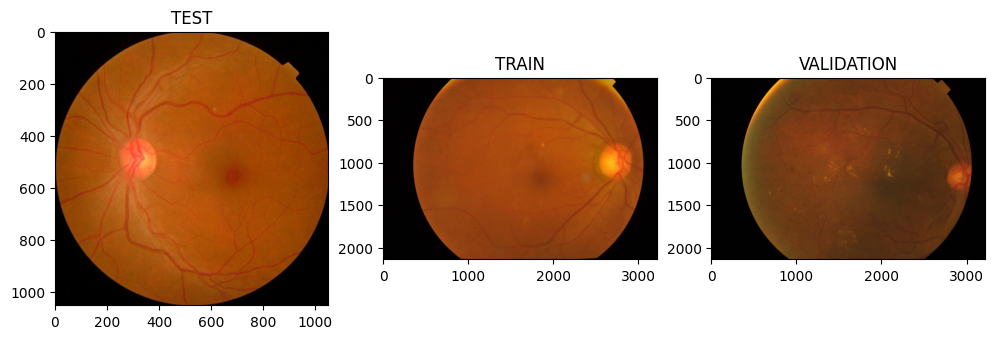

In [2]:
import matplotlib.pyplot as plt
import glob

# my_path = "drive/MyDrive/5980/"
my_path = "drive/MyDrive/"
test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [3]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")

2.5.1+cu121
Device: cuda


In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from functools import lru_cache

class CustomDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform

        # Normalize IDs in the labels DataFrame
        self.labels_df['id_code'] = self.labels_df['id_code'].str.lower().str.strip()

    def __len__(self):
        return len(self.labels_df)

    @lru_cache(maxsize = 10_000)
    def __getitem__(self, idx):
        # Get image ID and label
        image_id = self.labels_df.iloc[idx]['id_code']
        label = self.labels_df.iloc[idx]['diagnosis']

        # Construct image path using os.path.join for platform-independent path handling
        image_path = os.path.join(self.image_dir, f"{image_id}.png")

        # Debug: Check the file path
        # print(f"Looking for: {image_path}")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        # Load the image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label



Train Labels:
         id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0
Validation Labels:
         id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Test Labels:
         id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


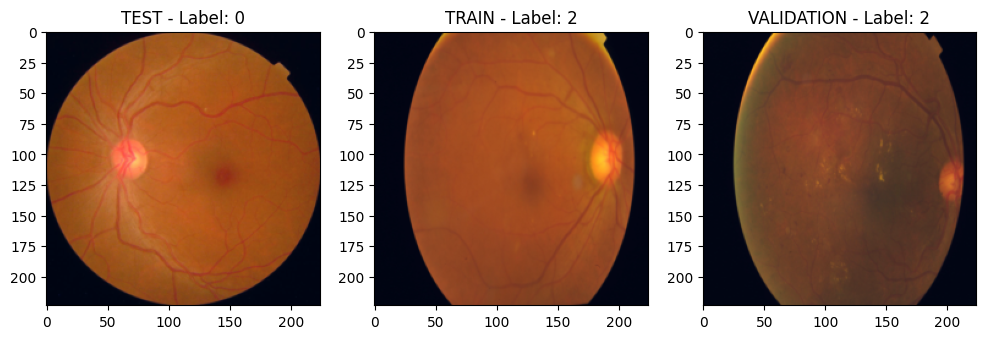

In [5]:
import pandas as pd
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

train_csv_path = "./" + my_path + "APTOS/train_1.csv"
val_csv_path = "./" + my_path + "APTOS/valid.csv"
test_csv_path = "./" + my_path + "APTOS/test.csv"

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))
test_images = sorted(glob.glob(test_image_path + '/*.png'))

# Verify CSV contents
print("Train Labels:\n", train_labels.head())
print("Validation Labels:\n", val_labels.head())
print("Test Labels:\n", test_labels.head())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_and_transform(image_path, transform):
    image = Image.open(image_path)
    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
    return transformed_image

def get_label(image_path, labels_df):
    image_id = os.path.splitext(os.path.basename(image_path))[0].lower().strip()
    labels_df['id_code'] = labels_df['id_code'].str.lower().str.strip()
    if image_id in labels_df['id_code'].values:
        label = labels_df.loc[labels_df['id_code'] == image_id, 'diagnosis'].values[0]
        return label
    else:
        return "Label Not Found"

train_image_transformed = load_and_transform(train_images[0], transform)
val_image_transformed = load_and_transform(val_images[0], transform)
test_image_transformed = load_and_transform(test_images[0], transform)

train_label = get_label(train_images[0], train_labels)
val_label = get_label(val_images[0], val_labels)
test_label = get_label(test_images[0], test_labels)

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(test_image_transformed)
ax[0].set_title(f'TEST - Label: {test_label}')

ax[1].imshow(train_image_transformed)
ax[1].set_title(f'TRAIN - Label: {train_label}')

ax[2].imshow(val_image_transformed)
ax[2].set_title(f'VALIDATION - Label: {val_label}')

plt.show()


In [6]:
from torch.utils.data import DataLoader

from pathlib import Path

train_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/train_images/train_images",
    labels_csv="./" + my_path + "APTOS/train_1.csv",
    transform=transform
)

val_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/val_images/val_images",
    labels_csv="./" + my_path + "APTOS/valid.csv",
    transform=transform
)

test_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/test_images/test_images",
    labels_csv="./" + my_path + "APTOS/test.csv",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [7]:
# Manually check the first 5 images and their labels
for i in range(5):
    image, label = train_dataset[i]
    print(f"Image {i}: Label = {label}")
    print(f"Image Path: {train_dataset.image_dir}/{train_dataset.labels_df.iloc[i]['id_code']}.png")



Image 0: Label = 2
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1ae8c165fd53.png
Image 1: Label = 1
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b329a127307.png
Image 2: Label = 4
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b32e1d775ea.png
Image 3: Label = 0
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b3647865779.png
Image 4: Label = 0
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b398c0494d1.png


In [ ]:
from tqdm.auto import tqdm


def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

In [ ]:
import torch
from torch import nn, optim
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models import densenet121, DenseNet121_Weights, densenet161, DenseNet161_Weights, densenet169, DenseNet169_Weights, densenet201, DenseNet201_Weights
import matplotlib.pyplot as plt

def initialize_model(num_classes, device):
    weights = EfficientNet_B7_Weights.DEFAULT
    model = efficientnet_b7(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

def initialize_model_densenet121(num_classes, device):
    weights = DenseNet121_Weights.DEFAULT
    model = densenet121(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet161(num_classes, device):
    weights = DenseNet161_Weights.DEFAULT
    model = densenet161(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet169(num_classes, device):
    weights = DenseNet169_Weights.DEFAULT
    model = densenet169(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet201(num_classes, device):
    weights = DenseNet201_Weights.DEFAULT
    model = densenet201(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def test_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = nn.Softmax(dim=1)(outputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_probabilities.extend(probabilities.cpu().numpy())

    return np.array(true_labels), np.array(predicted_probabilities)

def plot_learning_curves(training_losses, validation_losses, model_name=''):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    plt.figure(figsize=(10,6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(validation_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model_name + ' Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='efficientnetb7', epochs=20, model_name=''):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='batch')

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_module(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        training_losses.append(train_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)
        validation_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch + 1}, f"{path}_best.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1}, f"{path}_epoch_{epoch + 1}.pth")
    plot_learning_curves(training_losses, validation_losses, model_name)

    return training_losses, validation_losses


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5

model = initialize_model(num_classes, device)

loss_module = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

model_densenet121 = initialize_model_densenet121(num_classes, device)
optimizer_densenet121 = optim.AdamW(model_densenet121.parameters(), lr=1e-4)

model_densenet161 = initialize_model_densenet161(num_classes, device)
optimizer_densenet161 = optim.AdamW(model_densenet161.parameters(), lr=1e-4)

model_densenet169 = initialize_model_densenet169(num_classes, device)
optimizer_densenet169 = optim.AdamW(model_densenet169.parameters(), lr=1e-4)

model_densenet201 = initialize_model_densenet201(num_classes, device)
optimizer_densenet201 = optim.AdamW(model_densenet201.parameters(), lr=1e-4)


In [ ]:
try:
    train_losses, val_losses = train_model(
        model, loss_module, optimizer, train_loader, valid_loader,
         device=device, path="efficientnetb7", epochs=20, model_name='EfficientNet-B7'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

In [ ]:
# Load the best model checkpoint
checkpoint = torch.load("efficientnetb7_epoch_2.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

true_labels, predicted_probabilities = test_model(model, test_loader)

def accuracy(true_labels, predicted_probabilities):
  predicted_labels = [elem.argmax() for elem in predicted_probabilities]
  correct = 0
  for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
      correct +=1
  return correct/len(true_labels)

print("Accuracy:", accuracy(true_labels, predicted_probabilities))


In [ ]:
print(f"True Labels: {set(true_labels)}")
print(f"Predicted Probabilities: {predicted_probabilities[:10]}")  # Should contain values between 0 and 1


### ROC-AUC

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
def evaluate_roc_auc(true_labels, predicted_probabilities, model_name):
    # Binarize class labels
    true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure()

    # Set ROC curve colors
    colors = cycle(['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'darkblue'])

    # Plot ROC curve for each class
    for i, color in zip(range(5), colors):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Severity {i} ROC curve (area = {roc_auc[i]:0.2f})')

    # Plot micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binarized.ravel(), predicted_probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"],
         linestyle=':', linewidth=2, color='salmon',
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

    #Plot macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 5
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
         linestyle=':', linewidth=2, color='red',
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + ' Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

In [ ]:
roc_auc = evaluate_roc_auc(true_labels, predicted_probabilities, 'EfficientNet-B7')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc[cls]:.2f}")

### Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(true_labels, predicted_labels, model_name='', normalize=False):
    cm = confusion_matrix(true_labels, predicted_labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='viridis',
                xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name + ' Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()

    return cm

In [ ]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
cm_normalized = plot_confusion_matrix(true_labels, predicted_labels, 'EfficientNet-B7', normalize=True)

### Grad-CAM

In [ ]:
%pip install grad-cam

In [ ]:
#%pip install grad-cam
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_last_conv_layer(model, model_name):
    last_conv = None
    model_name = model_name.lower()
    if 'densenet' in model_name:
        last_conv = model.features.norm5
    elif 'inception' in model_name:
        last_conv = model.Mixed_7c
    elif 'resnet' in model_name:
        last_conv = model.layer4[-1].conv3
    elif 'efficientnet' in model_name:
        last_conv = model.features[-1]
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    return last_conv

def load_and_preprocess_image(image_path, transform):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transformed_image = transform(image)
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
    return transformed_image.unsqueeze(0), image

def visualize_gradcam(model, model_name, image_paths, true_labels, transform, device):
    target_layer = get_last_conv_layer(model, model_name)
    if target_layer is None:
        raise ValueError(f"No target layer found for model: {model_name}")
    cam = GradCAM(model=model, target_layers=[target_layer])

    model.eval()
    rows = 3
    cols = (len(image_paths) + 1) // rows
    fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))

    for i, image_path in enumerate(image_paths):

        row = i // cols
        col = i % cols

        input_tensor, image = load_and_preprocess_image(image_path, transform)

        # Get model prediction for the current image along with the probability that it is positive
        with torch.no_grad():
            outputs = model(input_tensor.to(device))
            probs = torch.softmax(outputs, dim=1)[0] # probability that it is positive
            predicted = torch.argmax(probs).item()
            confidence = probs[predicted].item()

        # Generate GradCAM heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        image_np = np.array(image, dtype=np.float32) / 255.0
        resized_cam = np.array(Image.fromarray(grayscale_cam).resize(image_np.shape[1::-1]))

        # Overlay GradCAM heatmap on the original image
        visualization = show_cam_on_image(image_np, resized_cam, use_rgb=True)

        ax[row, col].imshow(visualization)
        ax[row, col].axis('off')
        ax[row, col].set_title(f'Actual: {true_labels[i]} | Predicted: {predicted}\nConfidence: {confidence:.2f}')

    plt.tight_layout()
    plt.show()


In [ ]:
import random

def select_images(n_rows):
  no_dr_images = []
  mild_dr_images = []
  moderate_dr_images = []
  severe_dr_images = []
  proliferative_dr_images = []

  for idx, row in train_labels.iterrows():
          filename = os.path.join(train_image_path, f"{row['id_code']}.png")
          match row['diagnosis']:
              case 0:
                  no_dr_images.append(filename)
              case 1:
                  mild_dr_images.append(filename)
              case 2:
                  moderate_dr_images.append(filename)
              case 3:
                  severe_dr_images.append(filename)
              case 4:
                  proliferative_dr_images.append(filename)
  random_images = (
      random.sample(no_dr_images, n_rows) +
      random.sample(mild_dr_images, n_rows) +
      random.sample(moderate_dr_images, n_rows) +
      random.sample(severe_dr_images, n_rows) +
      random.sample(proliferative_dr_images, n_rows)
  )
  return random_images


In [ ]:
random_images = select_images(3)
true_labels = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]
print(random_images)

visualize_gradcam(model, 'efficientnet', random_images, true_labels, transform, device)

### DenseNet

In [ ]:
try:
    train_losses, val_losses = train_model(
        model_densenet121, loss_module, optimizer_densenet121, train_loader, valid_loader,
         device=device, path="densenet121", epochs=20, model_name='DenseNet-121'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet161, loss_module, optimizer_densenet161, train_loader, valid_loader,
         device=device, path="densenet161", epochs=20, model_name='DenseNet-161'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet169, loss_module, optimizer_densenet169, train_loader, valid_loader,
         device=device, path="densenet169", epochs=20, model_name='DenseNet-169'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet201, loss_module, optimizer_densenet201, train_loader, valid_loader,
         device=device, path="densenet201", epochs=20, model_name='DenseNet-201'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

In [ ]:
checkpoint_densenet121 = torch.load("densenet121_epoch_2.pth", map_location=device)
model_densenet121.load_state_dict(checkpoint_densenet121["model_state_dict"])

checkpoint_densenet161 = torch.load("densenet161_epoch_2.pth", map_location=device)
model_densenet161.load_state_dict(checkpoint_densenet161["model_state_dict"])

checkpoint_densenet169 = torch.load("densenet169_epoch_3.pth", map_location=device)
model_densenet169.load_state_dict(checkpoint_densenet169["model_state_dict"])

checkpoint_densenet201 = torch.load("densenet201_epoch_2.pth", map_location=device)
model_densenet201.load_state_dict(checkpoint_densenet201["model_state_dict"])

true_labels_densenet121, predicted_probabilities_densenet121 = test_model(model_densenet121, test_loader)
true_labels_densenet161, predicted_probabilities_densenet161 = test_model(model_densenet161, test_loader)
true_labels_densenet169, predicted_probabilities_densenet169 = test_model(model_densenet169, test_loader)
true_labels_densenet201, predicted_probabilities_densenet201 = test_model(model_densenet201, test_loader)

print(f"\nDenseNet-121 True Labels: {set(true_labels_densenet121)}")
print(f"DenseNet-161 True Labels: {set(true_labels_densenet161)}")
print(f"DenseNet-169 True Labels: {set(true_labels_densenet169)}")
print(f"DenseNet-201 True Labels: {set(true_labels_densenet201)}\n")

print(f"DenseNet-121 Predicted Probabilities: \n{predicted_probabilities_densenet121[:10]}\n")
print(f"DenseNet-161 Predicted Probabilities: \n{predicted_probabilities_densenet161[:10]}\n")
print(f"DenseNet-169 Predicted Probabilities: \n{predicted_probabilities_densenet169[:10]}\n")
print(f"DenseNet-201 Predicted Probabilities: \n{predicted_probabilities_densenet201[:10]}\n")


print("Accuracy DenseNet-121:", accuracy(true_labels_densenet121, predicted_probabilities_densenet121))
print("Accuracy DenseNet-161:", accuracy(true_labels_densenet161, predicted_probabilities_densenet161))
print("Accuracy DenseNet-169:", accuracy(true_labels_densenet169, predicted_probabilities_densenet169))
print("Accuracy DenseNet-201:", accuracy(true_labels_densenet201, predicted_probabilities_densenet201))


In [ ]:
roc_auc_densenet121 = evaluate_roc_auc(true_labels_densenet121, predicted_probabilities_densenet121, 'DenseNet-121')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet121[cls]:.2f}")

roc_auc_densenet161 = evaluate_roc_auc(true_labels_densenet161, predicted_probabilities_densenet161, 'DenseNet-161')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet161[cls]:.2f}")

roc_auc_densenet169 = evaluate_roc_auc(true_labels_densenet169, predicted_probabilities_densenet169, 'DenseNet-169')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet169[cls]:.2f}")

roc_auc_densenet201 = evaluate_roc_auc(true_labels_densenet201, predicted_probabilities_densenet201, 'DenseNet-201')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet201[cls]:.2f}")


In [ ]:
predicted_labels_densenet121 = np.argmax(predicted_probabilities_densenet121, axis=1)
cm_densenet121 = plot_confusion_matrix(true_labels_densenet121, predicted_labels_densenet121, 'DenseNet-121', normalize=True)
print(f'DenseNet-121 Confusion Matrix:\n {cm_densenet121}')

predicted_labels_densenet161 = np.argmax(predicted_probabilities_densenet161, axis=1)
cm_densenet161 = plot_confusion_matrix(true_labels_densenet161, predicted_labels_densenet161, 'DenseNet-161', normalize=True)
print(f'DenseNet-161 Confusion Matrix:\n {cm_densenet161}')

predicted_labels_densenet169 = np.argmax(predicted_probabilities_densenet169, axis=1)
cm_densenet169 = plot_confusion_matrix(true_labels_densenet169, predicted_labels_densenet169, 'DenseNet-169', normalize=True)
print(f'DenseNet-169 Confusion Matrix:\n {cm_densenet169}')

predicted_labels_densenet201 = np.argmax(predicted_probabilities_densenet201, axis=1)
cm_densenet201 = plot_confusion_matrix(true_labels_densenet201, predicted_labels_densenet201, 'DenseNet-201', normalize=True)
print(f'DenseNet-201 Confusion Matrix:\n {cm_densenet201}')

In [ ]:
visualize_gradcam(model_densenet121, 'densenet', random_images, true_labels, transform, device)

In [ ]:
visualize_gradcam(model_densenet161, 'densenet', random_images, true_labels, transform, device)

In [ ]:
visualize_gradcam(model_densenet169, 'densenet', random_images, true_labels, transform, device)

In [ ]:
visualize_gradcam(model_densenet201, 'densenet', random_images, true_labels, transform, device)